# COVID19DB PROJECT (www.covid19db.org): covid19 - confirmed cases, administrative division for United Kingdom


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [1]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)

# Retrieving epidemiology data for single source

In [2]:
# Load all data for region 1
sql_command = """SELECT * FROM epidemiology 
                 WHERE source = %(source)s AND adm_area_1 <> '' AND adm_area_2 IS NULL 
                 ORDER by date DESC"""
df = pd.read_sql(sql_command, conn, params={'source': 'GBR_PHTW'})
df.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined,gid
0,GBR_PHTW,2020-06-08,United Kingdom,GBR,England,None,None,NaN,NaN,None,36244.0,None,None,None,[GBR.1_1]
1,GBR_PHTW,2020-06-08,United Kingdom,GBR,Northern Ireland,None,None,59985.0,4802.0,None,537.0,None,None,None,[GBR.2_1]
2,GBR_PHTW,2020-06-08,United Kingdom,GBR,Scotland,None,None,127204.0,15639.0,None,2415.0,None,None,None,[GBR.3_1]
3,GBR_PHTW,2020-06-07,United Kingdom,GBR,England,None,None,NaN,155000.0,None,36192.0,None,None,None,[GBR.1_1]
4,GBR_PHTW,2020-06-07,United Kingdom,GBR,Northern Ireland,None,None,59984.0,4802.0,None,537.0,None,None,None,[GBR.2_1]


# Extracting only recent data - total per region

In [3]:
df_recent = df.copy()
df_recent['gid'] = [','.join(map(str, l)) for l in df['gid']]
df_recent = df_recent.sort_values('date').groupby('adm_area_1').apply(lambda x: x.max())

df_recent = df_recent.set_index('date')
df_recent[["country", "adm_area_1", "confirmed", "recovered", "dead", "gid"]].head(30)

,country,adm_area_1,confirmed,recovered,dead,gid
date,,,,,,
2020-06-08,United Kingdom,England,155000.0,None,36244.0,GBR.1_1
2020-06-08,United Kingdom,Northern Ireland,4802.0,None,537.0,GBR.2_1
2020-06-08,United Kingdom,Scotland,15639.0,None,2415.0,GBR.3_1
2020-06-07,United Kingdom,Wales,14438.0,None,1401.0,GBR.4_1


### Retrieving administrative division level 1 for single country from covid19db

In [4]:
# Get Covid19db administrative division
import geopandas as gpd
def get_administrative_division(level=0, countrycode=None):
    sql = f"SELECT * FROM administrative_division WHERE adm_level={level} "
    if level>0 and countrycode: 
        sql = sql +  f"AND countrycode='{countrycode}'"

    admin_data = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geometry')
    admin_data["area"] = admin_data['geometry'].area
    return admin_data

In [5]:
admin_1_data = get_administrative_division(level=1, countrycode='GBR')
admin_1_data.head()

,country,countrycode,countrycode_alpha2,adm_level,adm_area_1,adm_area_1_code,adm_area_2,adm_area_2_code,adm_area_3,adm_area_3_code,gid,latitude,longitude,properties,geometry,area
0,United Kingdom,GBR,GB,1,England,GBR.1_1,None,None,None,None,GBR.1_1,52.589902,-1.461575,"{'CC_1': None, 'GID_0': 'GBR', 'GID_1': 'GBR.1...","MULTIPOLYGON (((-4.63632 50.35447, -4.63361 50...",17.355468
1,United Kingdom,GBR,GB,1,Northern Ireland,GBR.2_1,None,None,None,None,GBR.2_1,54.612021,-6.691186,"{'CC_1': None, 'GID_0': 'GBR', 'GID_1': 'GBR.2...","MULTIPOLYGON (((-8.15136 54.45805, -8.17157 54...",1.960249
2,United Kingdom,GBR,GB,1,Scotland,GBR.3_1,None,None,None,None,GBR.3_1,56.851225,-4.180949,"{'CC_1': None, 'GID_0': 'GBR', 'GID_1': 'GBR.3...","MULTIPOLYGON (((-0.75990 60.42760, -0.73177 60...",11.682870
3,United Kingdom,GBR,GB,1,Wales,GBR.4_1,None,None,None,None,GBR.4_1,52.335229,-3.763468,"{'CC_1': None, 'GID_0': 'GBR', 'GID_1': 'GBR.4...","MULTIPOLYGON (((-4.91848 51.69910, -4.89802 51...",2.759039


# Merge administrative division and epidemiology data

In [6]:
data_pd = df_recent.merge(admin_1_data, how = 'outer', left_on = 'gid', right_on = 'gid', suffixes=('', '_y'))
data_pd = gpd.GeoDataFrame(data_pd, geometry='geometry')
data_pd.head()

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,...,adm_area_1_code,adm_area_2_y,adm_area_2_code,adm_area_3_y,adm_area_3_code,latitude,longitude,properties,geometry,area
0,GBR_PHTW,United Kingdom,GBR,England,None,None,NaN,155000.0,None,36244.0,...,GBR.1_1,None,None,None,None,52.589902,-1.461575,"{'CC_1': None, 'GID_0': 'GBR', 'GID_1': 'GBR.1...","MULTIPOLYGON (((-4.63632 50.35447, -4.63361 50...",17.355468
1,GBR_PHTW,United Kingdom,GBR,Northern Ireland,None,None,59985.0,4802.0,None,537.0,...,GBR.2_1,None,None,None,None,54.612021,-6.691186,"{'CC_1': None, 'GID_0': 'GBR', 'GID_1': 'GBR.2...","MULTIPOLYGON (((-8.15136 54.45805, -8.17157 54...",1.960249
2,GBR_PHTW,United Kingdom,GBR,Scotland,None,None,127204.0,15639.0,None,2415.0,...,GBR.3_1,None,None,None,None,56.851225,-4.180949,"{'CC_1': None, 'GID_0': 'GBR', 'GID_1': 'GBR.3...","MULTIPOLYGON (((-0.75990 60.42760, -0.73177 60...",11.682870
3,GBR_PHTW,United Kingdom,GBR,Wales,None,None,94512.0,14438.0,None,1401.0,...,GBR.4_1,None,None,None,None,52.335229,-3.763468,"{'CC_1': None, 'GID_0': 'GBR', 'GID_1': 'GBR.4...","MULTIPOLYGON (((-4.91848 51.69910, -4.89802 51...",2.759039


# Plotting functions

In [7]:
from termcolor import colored
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt

def choropleth_administrative_division(data, hue, label=None, cmap='Reds', k=10, add_text=False):
    schema = mc.Quantiles(data[hue], k=k) 
    gplt.choropleth(
        data,     
        hue=hue,     
        edgecolor='white', 
        linewidth=1,
        cmap=cmap,
        scheme=schema,
        legend=True, 
        legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
    )
    if add_text:
        label = label or hue
        for _, row in data.iterrows():
          plt.text(s=row[label], x = row['longitude'], y = row['latitude'],
                   horizontalalignment='center', 
                   fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'darkgray',})
        
        
def plot_time_series(data, col):
    for key, grp in df.groupby(['adm_area_1']): 
        grp = grp[grp[col].notna()] # Drop NA
        plt.plot(grp.date, grp[col], '-o', linewidth=4.0, label=key)
#         if not grp[col].is_monotonic_decreasing:
#             print(colored(f'Series in not monotonic increasing: {key}', 'red'))
#             print(grp[['date', col]])

    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5)) 
    plt.grid()
    plt.title(f'{col} cases per adm_area_1');
    plt.show()

# Plot epidemiology total confirmed

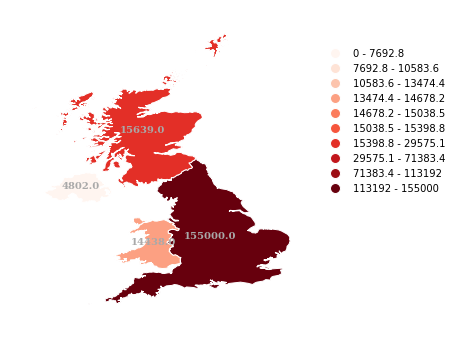

In [8]:
data_pd['confirmed'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'confirmed', add_text=True)

# Plot epidemiology total deaths

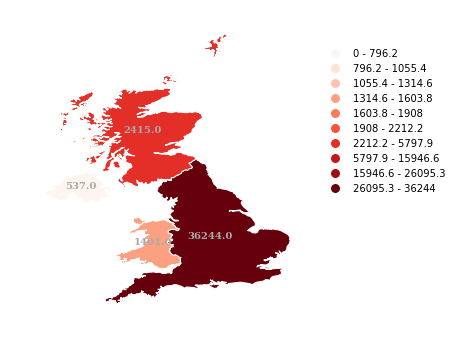

In [9]:
data_pd['dead'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'dead', add_text=True)

# Confirmed cases

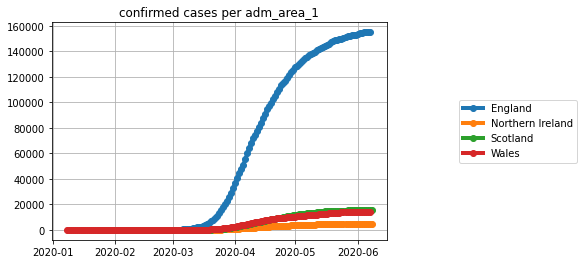

In [10]:
plot_time_series(df, 'confirmed')

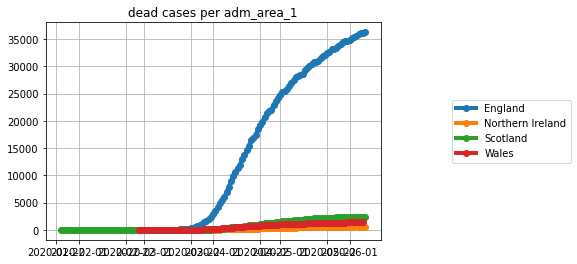

In [11]:
plot_time_series(df, 'dead')